In [1]:
import sys
sys.argv = ['']   

In [2]:
import torch  
import numpy as np
from PIL import Image  
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from MIC_mod.seg.tools import test 
from skimage.transform import resize
from scipy.special import softmax 

In [3]:
args = test.get_arguments() 

In [4]:
args

Namespace(aug_test=False, checkpoint='/home/sidd_s/scratch/mic_checkpoints/csHR2dzurHR_mic_hrda_aef07/iter_40000_relevant.pth', config='/home/sidd_s/scratch/mic_checkpoints/csHR2dzurHR_mic_hrda_aef07/csHR2dzurHR_mic_hrda_aef07.py', eval='eval', eval_options=None, format_only=False, gpu_collect=False, hrda_out='', inference_mode='same', launcher='none', local_rank=0, opacity=0.5, options=None, out=None, show=False, show_dir=None, test_set=False, tmpdir=None)

In [5]:
mic_model, dataloader = test.main() 

2023-05-16 22:00:17,935 - mmseg - INFO - Loaded 50 images from /home/sidd_s/scratch/dataset/dark_zurich/rgb_anon/val
/home/sidd_s/Diffusion_conditional_prior_segmentation/diffusion_plug_prior_mod/mmseg/models/backbones/mix_transformer.py:216: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


Use load_from_local loader


In [10]:
# mic_model
# len(dataloader) # 50
# dataloader

In [6]:
d = next(iter(dataloader))['img_metas'][0]

In [7]:
d

DataContainer([[{'filename': '/home/sidd_s/scratch/dataset/dark_zurich/rgb_anon/val/night/GOPR0356/GOPR0356_frame_000452_rgb_anon.png', 'ori_filename': 'night/GOPR0356/GOPR0356_frame_000452_rgb_anon.png', 'ori_shape': (1080, 1920, 3), 'img_shape': (256, 512, 3), 'pad_shape': (256, 512, 3), 'scale_factor': array([0.26666668, 0.23703703, 0.26666668, 0.23703703], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]])

In [8]:
dc = next(iter(dataloader))['img_metas'][0].data[0][0]['filename']
dc

'/home/sidd_s/scratch/dataset/dark_zurich/rgb_anon/val/night/GOPR0356/GOPR0356_frame_000452_rgb_anon.png'

In [9]:
for i, data in tqdm(enumerate(dataloader)):  
    # print(data['img_metas'][0].data[0][0]['filename'])
    if (data['img_metas'][0].data[0][0]['filename'] == '/home/sidd_s/scratch/dataset/dark_zurich/rgb_anon/val/night/GOPR0356/GOPR0356_frame_000363_rgb_anon.png'):
        with torch.no_grad():
            seg_logits = mic_model(return_loss=False, logits_output=True, **data)   
            seg_pred = mic_model(return_loss=False,  logits_output=False, **data) 
        break
    else: 
        continue   
print(data)  

35it [00:01, 21.20it/s]/home/sidd_s/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
35it [00:02, 13.65it/s]

{'img_metas': [DataContainer([[{'filename': '/home/sidd_s/scratch/dataset/dark_zurich/rgb_anon/val/night/GOPR0356/GOPR0356_frame_000363_rgb_anon.png', 'ori_filename': 'night/GOPR0356/GOPR0356_frame_000363_rgb_anon.png', 'ori_shape': (1080, 1920, 3), 'img_shape': (256, 512, 3), 'pad_shape': (256, 512, 3), 'scale_factor': array([0.26666668, 0.23703703, 0.26666668, 0.23703703], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]])], 'img': [tensor([[[[-1.8097, -1.8610, -1.7925,  ..., -1.6384, -1.7240, -1.6555],
          [-1.8097, -1.8097, -1.8097,  ..., -1.6555, -1.7069, -1.6555],
          [-1.6042, -1.7240, -1.7925,  ..., -1.6555, -1.6727, -1.6727],
          ...,
          [-0.7822, -0.8164, -0.7650,  ..., -1.0904, -1.1589, -1.0733],
          [-0.8164, -0.7650, -0.8335,  ..., -0.9020, -1.0562, -1.1418],
          [-0.8164, -0.

In [10]:
data['img'][0].shape

torch.Size([1, 3, 256, 512])

In [11]:
def train_label_img_to_color(img): 
    label_to_color = {
        0: [128, 64,128],
        1: [244, 35,232],
        2: [ 70, 70, 70],
        3: [102,102,156],
        4: [190,153,153],
        5: [153,153,153],
        
        6: [250,170, 30],
        7: [220,220,  0],
        8: [107,142, 35],
        9: [152,251,152],
        10: [ 70,130,180],
        11: [220, 20, 60],
        12: [255,  0,  0],
        13: [  0,  0,142],
        14: [  0,  0, 70],
        15: [  0, 60,100],
        16: [  0, 80,100],
        17: [  0,  0,230],
        18: [119, 11, 32],
        19 : [0,  0, 0] 
        } 
    img_height, img_width = img.shape 
    img_color = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for row in range(img_height):
        for col in range(img_width):
            label = img[row][col] 
            img_color[row, col] = np.array(label_to_color[label])  
    return img_color

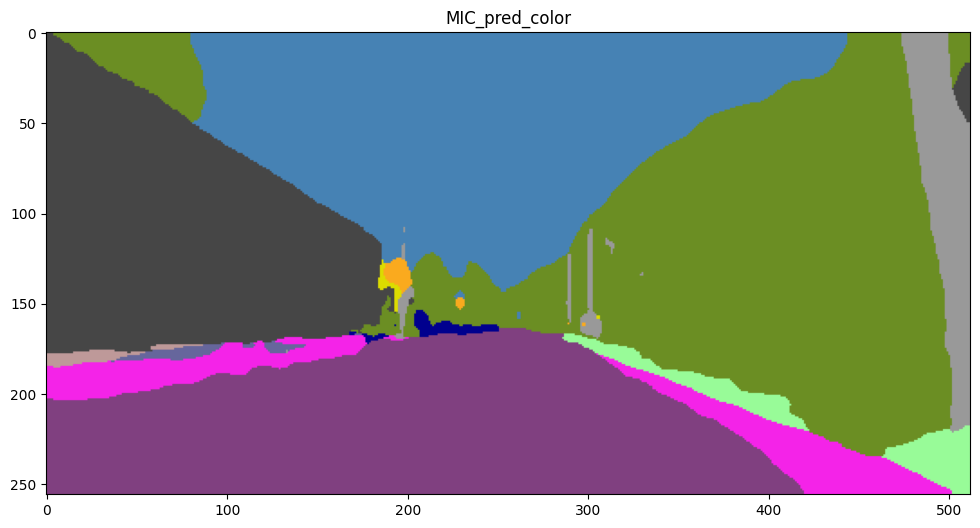

In [12]:
# Visualize
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.imshow(train_label_img_to_color(seg_pred[0]))
ax.set_title('MIC_pred_color')
plt.show()

In [13]:
lweak = torch.tensor(seg_logits[0])
lweak.shape

torch.Size([19, 256, 512])

In [14]:
lweak_onehot = F.one_hot(lweak.argmax(dim=0), num_classes=19)
lweak_onehot = lweak_onehot.permute(2,0,1).unsqueeze(dim=0)

In [15]:
lweak_onehot.shape

torch.Size([1, 19, 256, 512])

In [16]:
## increasing the channel number of lweak_onehot and z_prob to 20 for taking background into consideration 
background = torch.zeros(1,1,256,512)
lweak_onehot = torch.cat((lweak_onehot, background), dim = 1) 

In [17]:
lweak_onehot.shape

torch.Size([1, 20, 256, 512])

In [18]:
mic_pred_logits = seg_logits[0]

In [22]:
mic_pred_logits.shape

(19, 256, 512)

In [21]:
mic_pred_label = np.argmax(mic_pred_logits, axis=0)  

In [22]:
mic_pred_label.shape

(256, 512)

In [23]:
uns, cns = np.unique(mic_pred_label, return_counts=True)

In [24]:
uns

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13])

In [25]:
cns

array([27531,  5514, 21663,   500,   489,  5037,   271,   208, 36485,
        1561, 31466,   347])

In [26]:
mic_pred_label

array([[2, 2, 2, ..., 8, 8, 8],
       [2, 2, 2, ..., 8, 8, 8],
       [2, 2, 2, ..., 8, 8, 8],
       ...,
       [0, 0, 0, ..., 9, 9, 9],
       [0, 0, 0, ..., 9, 9, 9],
       [0, 0, 0, ..., 9, 9, 9]])

In [27]:
mic_pred_label.shape

(256, 512)

In [28]:
u, c = np.unique(seg_pred[0], return_counts=True)

In [29]:
u

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13])

In [30]:
c

array([27474,  5755, 21661,   390,   359,  4846,   231,   108, 36957,
        2337, 30605,   349])

In [33]:
mic_pred_color = Image.fromarray(train_label_img_to_color(np.argmax(seg_logits[0], axis=0)))
mic_pred_color.save('/home/sidd_s/Diffusion_conditional_prior_segmentation/diffusion_plug_prior_mod/experiments/miou_calc/mic_pred/MIC_prediction.png')

In [34]:
mic_pred_color = Image.fromarray(train_label_img_to_color(seg_pred[0]))
mic_pred_color.save('/home/sidd_s/Diffusion_conditional_prior_segmentation/diffusion_plug_prior_mod/experiments/miou_calc/mic_pred/MIC_prediction.png')